# Trading with momentum strategy 

## Description of the project

In this project,  we are going to implement a momentum trading strategy, and test to see if it has the potential to be profitable. We will select a universe of stock composed of 500 stocks with at least eight years of data and the highest average daily trading volume in dollar terms over the relevant period.

 We will also ultimately provide a textual description of how to generate a trading signal based on a momentum indicator. We will then compute the signal for the time range given and apply it to the universe dataset to produce projected returns. 
 
Finally, we will perform a statistical test on the mean of the returns to conclude if there is alpha in the signal.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
idx = pd.IndexSlice
plt.style.use("seaborn")

## Market Data
### Load Data
The data we use for this project is end of day data. This contains data for many stocks, but we will systematically extract stocks with high liquidity. That means, we are going to use the universe of most traded stocks.

In [4]:
DATA_STORE = Path('stock_prices.h5')

In [5]:
DATA_STORE

WindowsPath('stock_prices.h5')

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    data = store[list(store.keys())[0]].loc[idx[:, '2006':'2016'], :]
    

In [7]:
data

open       high        low      close     volume
ticker date                                                             
A      2006-01-03  22.786839  22.909642  22.387796  22.855063  3796200.0
       2006-01-04  22.889175  23.080202  22.766372  22.916465  3001300.0
       2006-01-05  22.820951  23.516836  22.820951  23.516836  3458800.0
       2006-01-06  23.537304  23.735153  23.257585  23.639640  4396500.0
       2006-01-09  23.639640  23.741976  23.482724  23.571416  2920500.0
...                      ...        ...        ...        ...        ...
ZUMZ   2016-12-23  20.950000  21.500000  20.950000  21.350000   532292.0
       2016-12-27  21.200000  21.700000  21.200000  21.450000   308004.0
       2016-12-28  21.550000  21.749900  21.325000  21.450000   165827.0
       2016-12-29  21.550000  22.050000  21.400000  21.900000   322108.0
       2016-12-30  21.900000  22.190000  21.600000  21.850000   295429.0

[7531907 rows x 5 columns]

In [8]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7531907 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7531907 non-null  float64
 1   high    7531907 non-null  float64
 2   low     7531907 non-null  float64
 3   close   7531907 non-null  float64
 4   volume  7531907 non-null  float64
dtypes: float64(5)
memory usage: 316.8+ MB


In [9]:
print(f"#Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

#Tickers: 3,186 | # Dates: 2,846


### Removing outliers
We compute daily returns and keep only inliers with values between chosen extrem values as a basic check against data error

In [10]:
daily_returns = data.groupby('ticker').close.pct_change()
daily_returns.describe(percentiles = [0.00001, 0.0001, 0.001, 0.999, 0.9999, 0.99999]).iloc[1:]

mean         0.000797
std          0.139972
min         -0.993615
0.001%      -0.713063
0.01%       -0.396673
0.1%        -0.192885
50%          0.000000
99.9%        0.232877
99.99%       0.587008
99.999%      1.891319
max        283.000000
Name: close, dtype: float64

Now we choose to keep only returns between -71% and 189%. That means, we choose to consider the values outside of this range as outliers. 

In [11]:
outliers = daily_returns[(daily_returns < daily_returns.quantile(0.00001)) | (daily_returns > daily_returns.quantile(0.99999))]
print(f"# observations: {len(outliers):,.0f} | # Tickers: {len(outliers.index.unique('ticker')):,.0f}")

# observations: 152 | # Tickers: 90


In [12]:
data = data.drop(outliers.index.unique('ticker'), level='ticker')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7340162 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 308.8+ MB


Note that we could also reduce the set of outliers by relaxing the outlier condition. For example, we could define as outlier any return of +100% or -100%

### Select the universe of stocks to build our trading strategy.

We will select the 500 most-traded stocks prior to 2017. We will then Compute the dollar volume as the product of the adjusted close price and the adjusted volume:


In [13]:
dv = data.close.mul(data.volume)
selected500Stocks = dv.groupby(level='date').rank(ascending=False).unstack('ticker').dropna(thresh=8*252, axis=1).mean().nsmallest(500)

In [14]:
selected500Stocks.index

Index(['AAPL', 'GOOGL', 'MSFT', 'BAC', 'XOM', 'C', 'JPM', 'GE', 'INTC', 'CSCO',
       ...
       'THC', 'BMRN', 'WSM', 'CMS', 'IGT', 'CPN', 'NUAN', 'CYH', 'RSG', 'SM'],
      dtype='object', name='ticker', length=500)

Now select the less liquide stocks. These are the stocks we will drop.

In [15]:
# Select the index to drop
to_drop = data.index.unique('ticker').difference(selected500Stocks.index)

Finally we are left with the most traded stocks.

In [16]:
data = data.drop(to_drop, level='ticker')
data.index.unique('ticker')

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACE', 'ACI', 'ACN', 'ADBE',
       ...
       'XEL', 'XL', 'XLNX', 'XOM', 'XRX', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZMH'],
      dtype='object', name='ticker', length=500)

In [17]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1366286 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1366286 non-null  float64
 1   high    1366286 non-null  float64
 2   low     1366286 non-null  float64
 3   close   1366286 non-null  float64
 4   volume  1366286 non-null  float64
dtypes: float64(5)
memory usage: 58.1+ MB


In [18]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,769


## Visualize a ticker and its daily returns 
Let's see what a single stock looks like from the closing prices. For this example, we'll use Apple's stock (AAPL). If we tried to graph all the stocks, it would be too much information.

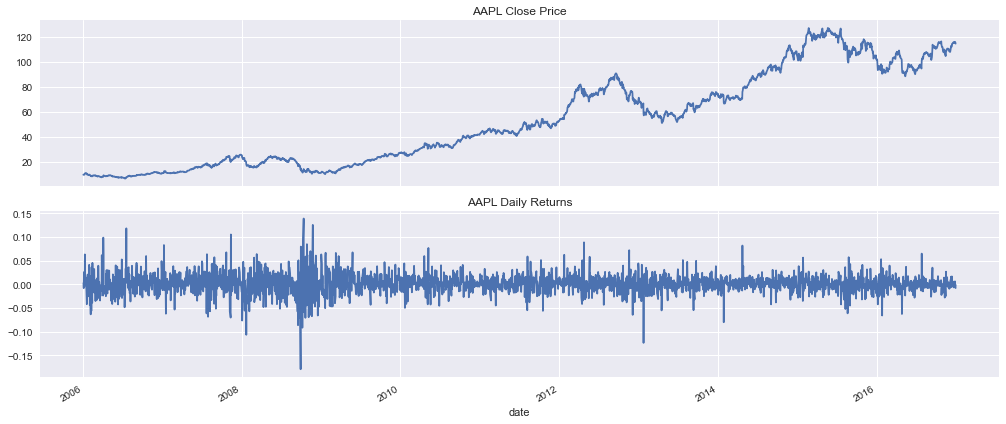

In [19]:
ticker = 'AAPL'
sample = data.loc[ticker, 'close']
fig, axes = plt.subplots(nrows=2, figsize=(14, 6), sharex=True)
sample.plot(ax=axes[0], title=f'{ticker} Close Price') # plot the closing prices 
sample.pct_change().plot(ax=axes[1], title=f'{ticker} Daily Returns')
sns.despine()
fig.tight_layout()

Now we select the closing prices of all the selected tickers. In the remaining of this work, we will use this DataFram to build the underlying strategy

In [20]:
data = data.close.unstack(level='ticker')

In [21]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2769 entries, 2006-01-03 to 2016-12-30
Columns: 500 entries, A to ZMH
dtypes: float64(500)
memory usage: 10.6 MB


In [22]:
data.describe()

ticker,A,AAL,AAP,AAPL,ABC,ABT,ACE,ACI,ACN,ADBE,...,XEL,XL,XLNX,XOM,XRX,YHOO,YUM,ZBH,ZION,ZMH
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2526.000000,2523.000000,2769.000000,2769.000000,...,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2387.000000
mean,28.570834,42.804122,78.740733,53.044571,43.352407,26.935983,64.491286,183.314788,54.356939,48.019617,...,21.564945,28.653819,29.306181,67.385949,38.182791,25.863028,34.995078,73.491906,32.569126,69.223554
std,8.925932,33.520068,47.403332,36.341816,27.931835,9.416903,24.199156,143.899771,27.781673,22.891896,...,8.354151,14.003854,11.069964,12.618859,10.280485,10.224993,15.358770,23.341095,18.849094,20.013368
min,8.487074,4.573082,23.489654,6.511801,12.073725,13.826036,26.907122,0.575000,20.574137,15.980000,...,11.174775,2.172513,11.698379,41.762290,13.618488,8.950000,12.844478,30.491182,6.204957,31.075281
25%,22.513943,21.254438,38.871477,18.958376,19.582642,19.559702,45.045937,46.983199,30.966844,32.330000,...,14.343380,18.087005,19.760111,56.281602,28.968815,15.940000,20.625286,56.522090,20.638781,55.254616
50%,26.252622,34.999668,63.967036,45.860199,33.904333,21.752021,53.917450,164.234365,47.289535,38.660000,...,19.212324,28.227015,27.373289,68.001129,37.826829,25.960000,33.336669,66.989490,26.853560,65.202843
75%,36.975953,46.717231,122.517507,83.646752,65.749600,35.771463,84.710556,296.611356,73.994089,63.900000,...,26.802466,35.467120,39.966395,77.397582,46.348269,33.760000,48.261936,92.644659,32.126614,80.341152
max,47.857603,163.565636,199.686773,126.931724,110.596794,48.530672,119.470000,673.299686,122.916703,110.810000,...,43.557720,64.111905,60.231455,92.545338,63.837054,52.370000,64.617839,131.742958,79.594546,121.296258


## Resample Adjusted Prices

The trading signal we will develop in this project does not need to be based on daily prices, for instance, we can use month-end prices to perform trading once a month. To do this, we must first resample the daily adjusted closing prices into monthly buckets, and select the last observation of each month.

Here, we implement $\textit{the resample_prices}$ to resample $\textit{close_prices}$ at the sampling frequency of $\textit{freq}$.

In [23]:
def resample_prices(close_prices, freq='M'):
    """
    Resample close prices for each ticker at specified frequency.
    
    Parameters
    ----------
    close_prices : DataFrame
        Close prices for each ticker and date
    freq : str
        What frequency to sample at
        For valid freq choices, see http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    
    Returns
    -------
    prices_resampled : DataFrame
        Resampled prices for each ticker and date
    """

    prices_resampled = close_prices.resample(freq).last()
    
    return  prices_resampled



### View Data
Let's apply this function to $data$ and view the results.

In [24]:
apple_ticker = 'AAPL'

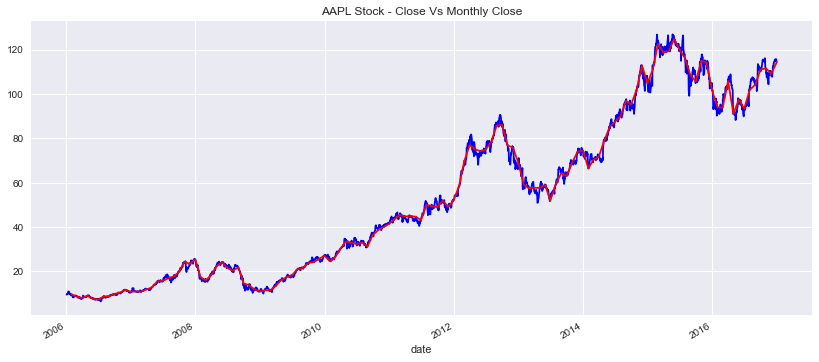

In [25]:
monthly_close = resample_prices(data)
    
data.loc[:, apple_ticker].plot(figsize=(14, 6), color='b')
monthly_close.loc[:, apple_ticker].plot(figsize=(14, 6), color='r')
plt.title('{} Stock - Close Vs Monthly Close'.format(apple_ticker))
plt.show()

In [26]:
monthly_close

ticker,A,AAL,AAP,AAPL,ABC,ABT,ACE,ACI,ACN,ADBE,...,XEL,XL,XLNX,XOM,XRX,YHOO,YUM,ZBH,ZION,ZMH
date,,,,,,,,,,,,,,,,,,,,,
2006-01-31,23.134782,76.235357,41.599853,9.704087,18.307734,15.184664,43.244630,380.703730,25.163015,39.73,...,12.022943,49.361994,21.330716,45.786010,45.904937,34.375,14.065063,65.433141,69.678689,66.686605
2006-02-28,24.560665,85.979140,39.480237,8.801920,19.304582,15.547125,44.018689,320.604167,26.064830,38.55,...,11.490516,49.281743,20.716980,43.549314,47.797593,32.060,13.561825,65.651412,73.052371,66.909055
2006-03-31,25.618138,103.933684,39.814549,8.060394,20.261626,14.945369,41.260053,333.731715,23.997839,34.95,...,11.370086,47.038246,19.334836,44.642265,48.759961,32.260,13.891630,64.152000,73.238277,65.380921
2006-04-30,26.211687,112.404279,38.456800,9.046096,18.112475,15.147426,44.060437,417.450297,23.199773,39.20,...,11.802337,48.344253,21.013154,46.270688,45.038806,32.780,14.728823,59.691731,73.503858,60.835206
2006-05-31,23.803378,121.342576,36.448862,7.681278,18.307647,15.133250,41.069658,424.525726,22.465553,28.63,...,11.758485,46.429266,19.806455,44.902755,44.044359,31.590,14.364022,57.461592,72.049249,58.562349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-31,46.415157,35.977253,157.019707,104.248477,85.065515,40.814597,NaN,NaN,111.567063,102.31,...,39.742936,33.300249,52.966459,83.222684,38.079447,42.750,63.586992,128.298180,30.331886,NaN
2016-09-30,46.637452,36.284497,148.839621,111.077195,79.011065,41.076852,NaN,NaN,118.523027,108.54,...,39.862590,32.910250,53.093477,83.356391,39.463005,43.100,63.657091,128.946887,30.758258,NaN
2016-10-31,43.151280,40.239022,139.816618,111.558644,68.780120,38.356164,NaN,NaN,113.938098,107.51,...,40.259859,33.957350,49.703077,79.574410,38.060568,41.550,60.837248,104.530087,31.938217,NaN


## Compute Log Returns

Compute log returns ($R_t$) from prices ($P_t$) as our primary momentum indicator:

$$R_t = log_e(P_t) - log_e(P_{t-1})$$

Implement the $\textit{compute_log_returns}$ function below, such that it accepts a dataframe (like one returned by $\textit{resample_prices}$), and produces a similar dataframe of log returns. 

In [27]:
def compute_log_returns(prices):
    """
    Compute log returns for each ticker.
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """
    log_returns = np.log(prices) - np.log(prices.shift(1))
    
    return log_returns



### View Data
Using the same data returned from $\textit{resample_prices}$, we'll generate the log returns.

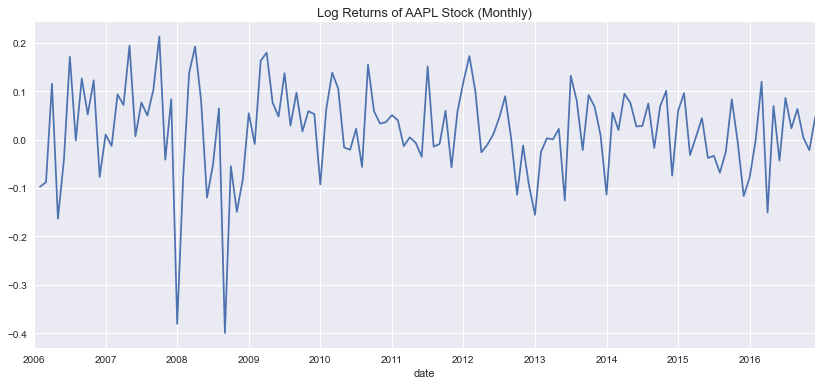

In [28]:
monthly_close_returns = compute_log_returns(monthly_close)
#project_helper.plot_returns(
    
monthly_close_returns.loc[:, apple_ticker].plot(figsize=(14, 6))
plt.title('Log Returns of {} Stock (Monthly)'.format(apple_ticker), fontsize=13)
plt.show()

## Shift Returns
Implement the $\textit{shift_returns}$ function to shift the log returns to the previous or future returns in the time series. For example, if the parameter $\textit{shift_n}$ is 2 and $\textit{returns}\,$ is the following:

```
                           Returns
               A         B         C         D
2013-07-08     0.015     0.082     0.096     0.020     ...
2013-07-09     0.037     0.095     0.027     0.063     ...
2013-07-10     0.094     0.001     0.093     0.019     ...
2013-07-11     0.092     0.057     0.069     0.087     ...
...            ...       ...       ...       ...
```

then the output of the $\textit{shift_returns}$ function would be:
```
                        Shift Returns
               A         B         C         D
2013-07-08     NaN       NaN       NaN       NaN       ...
2013-07-09     NaN       NaN       NaN       NaN       ...
2013-07-10     0.015     0.082     0.096     0.020     ...
2013-07-11     0.037     0.095     0.027     0.063     ...
...            ...       ...       ...       ...
```
Using the same $\textit{returns}$ data as above, the $\textit{shift_returns}$ function should generate the following with $\textit{shift_n}$ as -2:
```
                        Shift Returns
               A         B         C         D
2013-07-08     0.094     0.001     0.093     0.019     ...
2013-07-09     0.092     0.057     0.069     0.087     ...
...            ...       ...       ...       ...       ...
...            ...       ...       ...       ...       ...
...            NaN       NaN       NaN       NaN       ...
...            NaN       NaN       NaN       NaN       ...
```
_Note: The "..." represents data points we're not showing._

In [29]:
def shift_returns(returns, shift_n):
    """
    Generate shifted returns
    
    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    shift_n : int
        Number of periods to move, can be positive or negative
    
    Returns
    -------
    shifted_returns : DataFrame
        Shifted returns for each ticker and date
    """
    
    return returns.shift(shift_n)

### View Data
Let's get the previous month's and next month's returns.

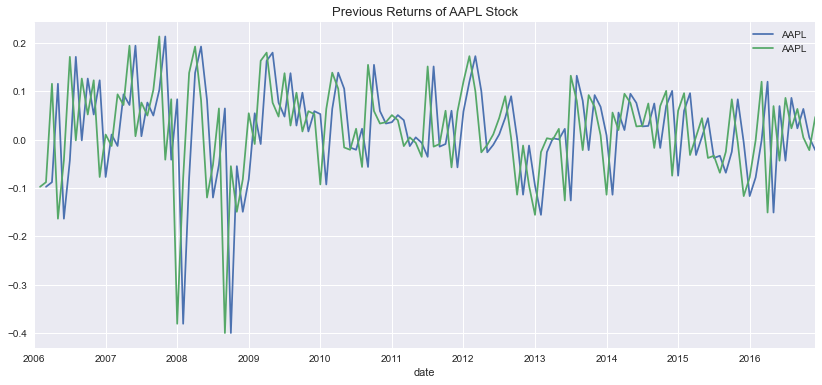

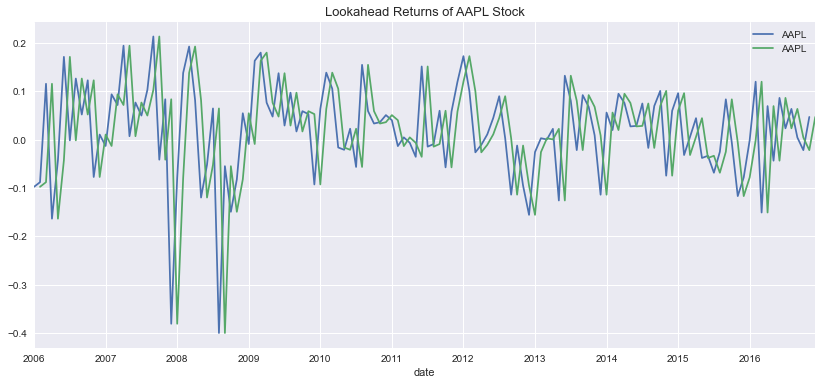

In [30]:
prev_returns = shift_returns(monthly_close_returns, 1)
lookahead_returns = shift_returns(monthly_close_returns, -1)

    
prev_returns.loc[:, apple_ticker].plot()
monthly_close_returns.loc[:, apple_ticker].plot(figsize=(14, 6))
plt.title('Previous Returns of {} Stock'.format(apple_ticker), fontsize=13)
plt.legend()
plt.show()

    
lookahead_returns.loc[:, apple_ticker].plot(figsize=(14, 6))
monthly_close_returns.loc[:, apple_ticker].plot()
plt.title('Lookahead Returns of {} Stock'.format(apple_ticker), fontsize=13)
plt.legend()
plt.show()

## Generate Trading Signal

A trading signal is a sequence of trading actions, or results that can be used to take trading actions. A common form is to produce a "long" and "short" portfolio of stocks on each date (e.g. end of each month, or whatever frequency we desire to trade at). This signal can be interpreted as rebalancing our portfolio on each of those dates, entering long ("buy") and short ("sell") positions as indicated.

Here's a strategy that we will try:
> For each month-end observation period, rank the stocks by _previous_ returns, from the highest to the lowest. Select the top performing stocks for the long portfolio, and the bottom performing stocks for the short portfolio.

We are going to implement the $\textit{get_top_n}$ function to get the top performing stock for each month. We will get the top performing stocks from $\textit{prev_returns}$ by assigning them a value of 1. For all other stocks, we give them a value of 0. For example, using the following $\textit{prev_returns}$:

```
                                     Previous Returns
               A         B         C         D         E         F         G
2013-07-08     0.015     0.082     0.096     0.020     0.075     0.043     0.074
2013-07-09     0.037     0.095     0.027     0.063     0.024     0.086     0.025
...            ...       ...       ...       ...       ...       ...       ...
```

The function $\textit{get_top_n}$ with $\textit{top_n}$ set to 3 should return the following:
```
                                     Previous Returns
               A         B         C         D         E         F         G
2013-07-08     0         1         1         0         1         0         0
2013-07-09     0         1         0         1         0         1         0
...            ...       ...       ...       ...       ...       ...       ...
```


In [31]:
def get_top_n(prev_returns, top_n):
    """
    Select the top performing stocks
    
    Parameters
    ----------
    prev_returns : DataFrame
        Previous shifted returns for each ticker and date
    top_n : int
        The number of top performing stocks to get
    
    Returns
    -------
    top_stocks : DataFrame
        Top stocks for each ticker and date marked with a 1
    """
    topStocks = prev_returns.copy()
    for date, row in prev_returns.iterrows():
        xx = row.isin(row.nlargest(top_n))
        topStocks.loc[date, :] = xx.astype(np.int)
    
    return topStocks.astype(np.int)

### View Data
We want to get the best performing and worst performing stocks. To get the best performing stocks, we'll use the $\textit{get_top_n}$ function. To get the worst performing stocks, we'll also use the $\textit{get_top_n}$ function. However, we pass in $-1$*$\textit{prev_returns}$ instead of just $\textit{prev_returns}$. Multiplying by negative one will flip all the positive returns to negative and negative returns to positive. Thus, it will return the worst performing stocks.

In [32]:
top_bottom_n = 100
df_long = get_top_n(prev_returns, top_bottom_n)
df_short = get_top_n(-1*prev_returns, top_bottom_n)

We are now going to the print the top 10 most traded with long positions and the top 10 most traded stocks with short position

In [33]:
def most_traded(df, top_n=10):
    return df.sum().sort_values(ascending=False).index[:top_n].values.tolist()

In [34]:
top_n=10
print('top 10 most Longed Stocks:\n', most_traded(df_long, top_n))
print('\n')
print('Top 10 most Shorted Stocks:\n', most_traded(df_short, top_n))


top 10 most Longed Stocks:
 ['UAL', 'GMCR', 'FSLR', 'DECK', 'SWKS', 'BIDU', 'BMRN', 'X', 'EXPE', 'NFLX']


Top 10 most Shorted Stocks:
 ['ACI', 'BTU', 'S', 'AAL', 'KBH', 'SUNE', 'ANR', 'RIG', 'CLF', 'JBLU']


## Projected Returns
It's now time to check if our trading signal has the potential to become profitable!

We'll start by computing the net returns this portfolio would return. For simplicity, we'll assume every stock gets an equal dollar amount of investment. This makes it easier to compute a portfolio's returns as the simple arithmetic average of the individual stock returns.

We are then goig to implement the $\textit{portfolio_returns}$ function to compute the expected portfolio returns. Using $\textit{df_long}$ to indicate which stocks to long and $\textit{df_short}$ to indicate which stocks to short, calculate the returns using $\textit{lookahead_returns}$. 



In [35]:
def portfolio_returns(df_long, df_short, lookahead_returns, n_stocks):
    """
    Compute expected returns for the portfolio, assuming equal investment in each long/short stock.
    
    Parameters
    ----------
    df_long : DataFrame
        Top stocks for each ticker and date marked with a 1
    df_short : DataFrame
        Bottom stocks for each ticker and date marked with a 1
    lookahead_returns : DataFrame
        Lookahead returns for each ticker and date
    n_stocks: int
        The number number of stocks chosen for each month
    
    Returns
    -------
    portfolio_returns : DataFrame
        Expected portfolio returns for each ticker and date
    """    
    
    return (df_long - df_short)*lookahead_returns/n_stocks


### View Data
Time to see how the portfolio did.

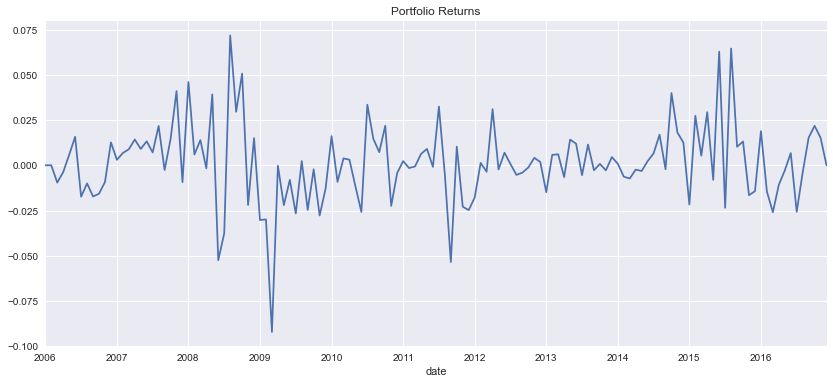

In [36]:
expected_portfolio_returns = portfolio_returns(df_long, df_short, lookahead_returns, 2*top_bottom_n)
expected_portfolio_returns.T.sum().plot(figsize=(14, 6))
plt.title('Portfolio Returns')
plt.show()

#, 'Portfolio Returns')

## Statistical Tests
### Annualized Rate of Return

In [37]:
expected_portfolio_returns_by_date = expected_portfolio_returns.T.sum().dropna()
portfolio_ret_mean = expected_portfolio_returns_by_date.mean()
portfolio_ret_ste = expected_portfolio_returns_by_date.sem()
portfolio_ret_annual_rate = (np.exp(portfolio_ret_mean * 12) - 1) * 100

print("""
Mean:                       {:.6f}
Standard Error:             {:.6f}
Annualized Rate of Return:  {:.2f}%
""".format(portfolio_ret_mean, portfolio_ret_ste, portfolio_ret_annual_rate))


Mean:                       0.001306
Standard Error:             0.001912
Annualized Rate of Return:  1.58%



The annualized rate of return allows us to compare the rate of return from this strategy to other quoted rates of return, which are usually quoted on an annual basis. 

### T-Test
Our null hypothesis ($H_0$) is that the actual mean return from the signal is zero. We'll perform a one-sample, one-sided t-test on the observed mean return, to see if we can reject $H_0$.

We'll need to first compute the t-statistic, and then find its corresponding p-value. The p-value will indicate the probability of observing a t-statistic equally or more extreme than the one we observed if the null hypothesis were true. A small p-value means that the chance of observing the t-statistic we observed under the null hypothesis is small, and thus casts doubt on the null hypothesis. It's good practice to set a desired level of significance or alpha ($\alpha$) _before_ computing the p-value, and then reject the null hypothesis if $p < \alpha$.

For this project, we'll use $\alpha = 0.05$, since it's a common value to use.

We are then going to implement the $\textit{analyze_alpha}$ function to perform a t-test on the sample of portfolio returns. 

We've imported the `scipy.stats` module for to perform the t-test.


In [38]:
from scipy import stats

def analyze_alpha(expected_portfolio_returns_by_date):
    """
    Perform a t-test with the null hypothesis being that the expected mean return is zero.
    
    Parameters
    ----------
    expected_portfolio_returns_by_date : Pandas Series
        Expected portfolio returns for each date
    
    Returns
    -------
    t_value
        T-statistic from t-test
    p_value
        Corresponding p-value
    """
    t_value, p_value = stats.ttest_1samp(expected_portfolio_returns_by_date, 0)

    return (t_value, p_value/2)



### View Data
Let's see what values we get with our portfolio. 

In [39]:
t_value, p_value = analyze_alpha(expected_portfolio_returns_by_date)
print("""
Alpha analysis:
 t-value:        {:.3f}
 p-value:        {:.6f}
""".format(t_value, p_value))


Alpha analysis:
 t-value:        0.683
 p-value:        0.247942



## Conclusion
We observed a p_value of 0.25 whis is way greater than our $\alpha=0.05$

Therefore, Under this strategy, we do not reject the null hypothesis H$_0$ given that p_value $= 0.24 > 0.05$. That means, having a mean return of zero, under this strategy, is likely to occur. We conclude that this strategy cannot be validated for trade. 
